In [145]:
import os
import matplotlib.pyplot as plt
import pandas as pd


from utils import load_egraph_data, get_egraph_from_dir, get_dataframes, parse_stop, prepare_step_data


data_dir = "../../data/"

egraph_data = get_egraph_from_dir(data_dir)

In [174]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

out_color_map = {
    "Saturated": "#9ebcda",
    "Timeout": "#8c6bb1",
    "NodeLimit": "#6e016b",
    "Equivalent": "#2ca02c"  # solved
}

# Default color for memory bars
memory_bar_color = "#7f7f7f"

def create_cactus_plot(
    df,
    name,
    dir_out=None,
    timeout=60000,
    bar_width=0.35
):
    """
    Create a transposed cactus plot with two bars per problem using separate y-axes,
    placing 'Equivalent' outcomes on the left side and others on the right side, each sorted by runtime:
    - x-axis: problem names
    - left y-axis: runtime (ms)
    - right y-axis: memory usage (MB)
    """
    # Ensure 'memory' exists
    if 'memory' not in df.columns:
        raise ValueError("Column 'memory' not found in DataFrame")

    # Split and sort data
    df_eq = df[df['outcome'] == 'Equivalent'].sort_values('runtime')
    df_neq = df[df['outcome'] != 'Equivalent'].sort_values('runtime')

    # Prepare x positions
    n_eq = len(df_eq)
    n_neq = len(df_neq)
    total = n_eq + n_neq
    x = np.arange(total)
    x_eq = x[:n_eq]
    x_neq = x[n_eq:]

    # Create plot
    fig, ax1 = plt.subplots(figsize=(max(6, total * 0.3), 5))
    ax2 = ax1.twinx()

    # Plot runtime bars on primary y-axis
    runtimes_eq = df_eq['runtime'].values
    runtimes_neq = df_neq['runtime'].values
    ax1.bar(x_eq - bar_width/2, runtimes_eq, width=bar_width, color=out_color_map['Equivalent'], label='Runtime (Equivalent)')
    ax1.bar(x_neq - bar_width/2, runtimes_neq, width=bar_width, color=[out_color_map.get(o, 'gray') for o in df_neq['outcome']], label='Runtime (Others)')
    ax1.set_ylabel('Runtime (ms)')
    if name != 'Rover':
        ax1.set_yscale('log')

    # Plot memory bars on secondary y-axis
    mem_eq = df_eq['memory'].astype(float).values
    mem_neq = df_neq['memory'].astype(float).values
    ax2.bar(x_eq + bar_width/2, mem_eq, width=bar_width, color=memory_bar_color, label='Memory (Equivalent)')
    ax2.bar(x_neq + bar_width/2, mem_neq, width=bar_width, color=memory_bar_color, label='Memory (Others)')
    ax2.set_ylabel('Memory (MB)')
    if name != 'Rover':
        ax2.set_yscale('log')


    # X-axis labels
    labels = list(df_eq.index) + list(df_neq.index)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
    ax1.set_xlabel('Problem')
    ax1.set_title(f'{name}: Runtime (left) and Memory Usage (right)')
    # Timeout line on runtime axis
    if timeout and n_neq > 0:
        ax1.axhline(timeout, color='red', linestyle='--', label=f'Timeout at {timeout/1000:.3g}s')

    # Legend
    handles = []
    handles.append(Patch(facecolor=out_color_map['Equivalent'], label=f"Equivalent: {n_eq}/{n_eq + n_neq}"))
    for o in sorted(df_neq['outcome'].unique()):
        count = (df_neq['outcome'] == o).sum()
        handles.append(Patch(facecolor=out_color_map[o], label=f"{o}: {count}"))
    handles.append(Patch(facecolor=memory_bar_color, label='Memory (MB)'))
    # handles.append(Patch(facecolor='grey',
    #                     # edgecolor='black',
    #                     hatch='///',
    #                     label='Runtime (ms)'))
    if timeout:
        handles.extend(ax1.lines)
    ax1.legend(handles=handles, loc='center left')

    plt.tight_layout()
    if dir_out:
        plt.savefig(dir_out)
    plt.show()


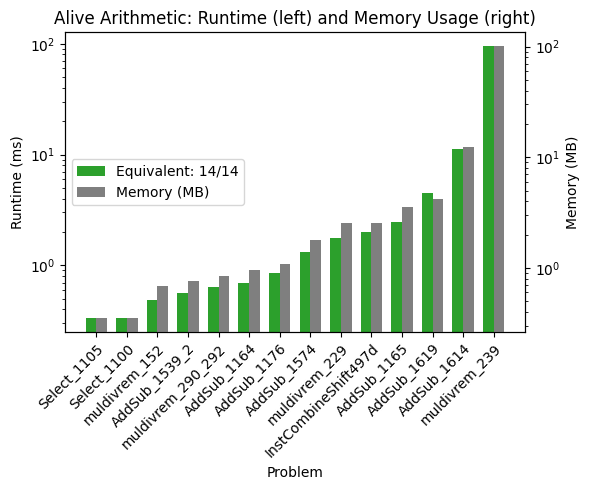

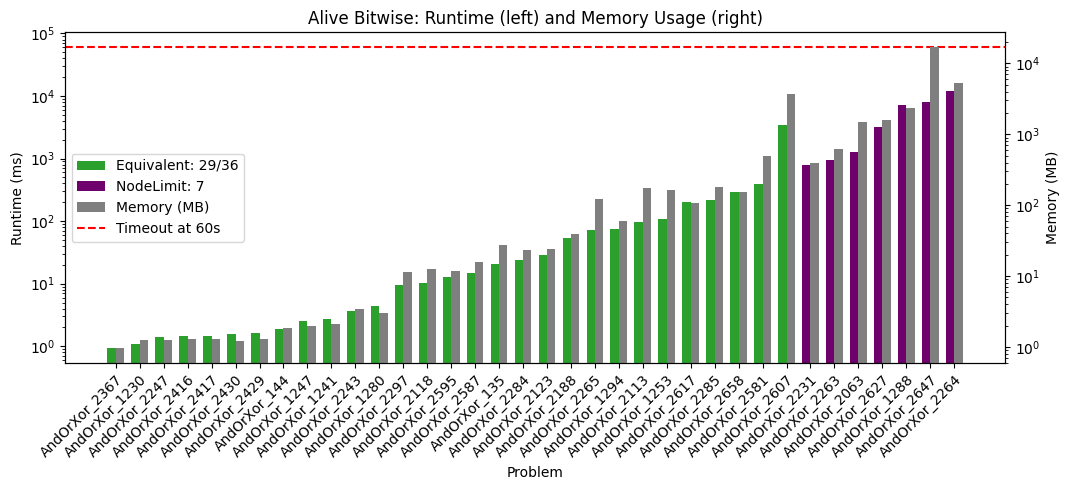

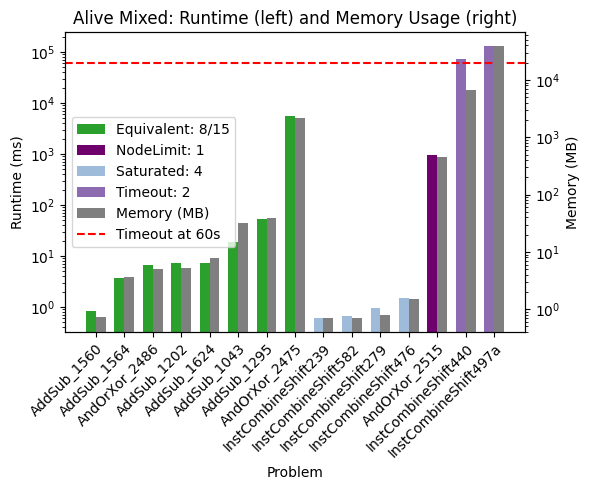

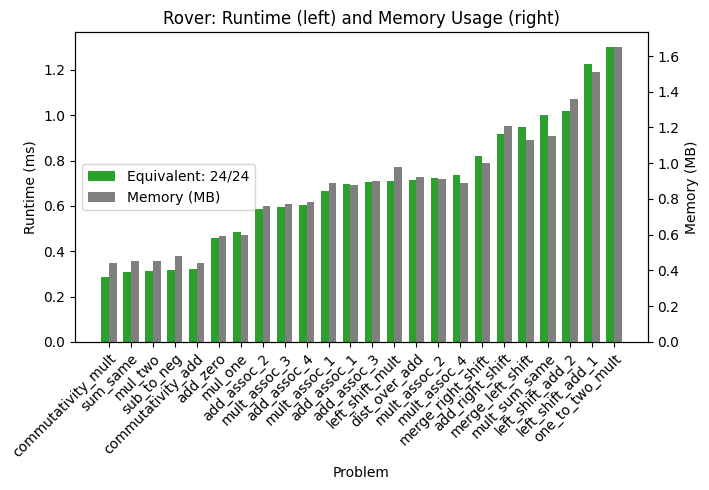

In [175]:

out_dir = "../../out/results/"
os.makedirs(out_dir, exist_ok=True)

dataframes = get_dataframes(egraph_data)

benchmark_names = {
    "alive_arith": "Alive Arithmetic",
    "alive_bitwise": "Alive Bitwise",
    "alive_mixed": "Alive Mixed",
    "rover": "Rover",
}

for test_set, df in dataframes.items():

    order = [
            "stop_reason",
            "runtime",
            "memory",
            "egraph_nodes",
            "egraph_classes",
            "iterations",
        ]

    out_df = df[order
    ].copy()

    create_cactus_plot(out_df.rename(columns={"stop_reason": "outcome"}), benchmark_names[test_set],f"{out_dir}{test_set}_cactus.pdf")
    out_df["runtime"] = df["runtime"].map(lambda x: f"{x:.3f}")

    renaming = {
            "test": "Test",
            "stop_reason": "Proof Result",
            "runtime": "Run-time (ms)",
            "memory": "Memory (MB)",
            "egraph_nodes": "Nodes",
            "egraph_classes": "E-classes",
            "iterations": "Iterations",
        }
    renaming = {k: r'\textbf{'+v+r'}' for k, v in renaming.items()}


    out_df['test'] = out_df.index.map(lambda x: r'\texttt{' + x + '}')

    with open(f"{out_dir}{test_set}_main.tex", "w") as f:
        f.write(out_df[['test', 'stop_reason', 'runtime', 'memory']].rename(columns=renaming).to_latex(index=False,  column_format='llrr').replace("_", r"\_"))

    with open(f"{out_dir}{test_set}_all.tex", "w") as f:
        f.write(out_df[['test'] + order].rename(columns=renaming).to_latex(index=False).replace("_", r"\_"))


    # print(out_df)

In [ ]:


summary_table = pd.concat(
    [df['stop_reason'].value_counts().rename(benchmark_names[name]) 
     for name, df in dataframes.items() if name != 'rover'],
    axis=1
).fillna(0).astype(int).T

summary_table['Total'] = summary_table.sum(axis=1)
summary_table['TotalFail'] = summary_table.drop('Equivalent', axis=1).drop('Total', axis=1).sum(axis=1)

# Add column totals (sum of each column)
summary_table.loc['Total'] = summary_table.sum(axis=0)

summary_table['Family'] = summary_table.index + ' (' + summary_table['Total'].astype(str) + ')'

with open(f"{out_dir}alive_summary.tex", 'w') as f:
    f.write(summary_table[['Family', 'Equivalent', 'NodeLimit', 'Saturated', 'Timeout', 'TotalFail']].to_latex(index=False))

summary_table


stop_reason,Equivalent,NodeLimit,Saturated,Timeout,Total,TotalFail,Family
Alive Arithmetic,14,0,0,0,14,0,Alive Arithmetic (14)
Alive Bitwise,29,7,0,0,36,7,Alive Bitwise (36)
Alive Mixed,8,1,4,2,15,7,Alive Mixed (15)
Total,51,8,4,2,65,14,Total (65)


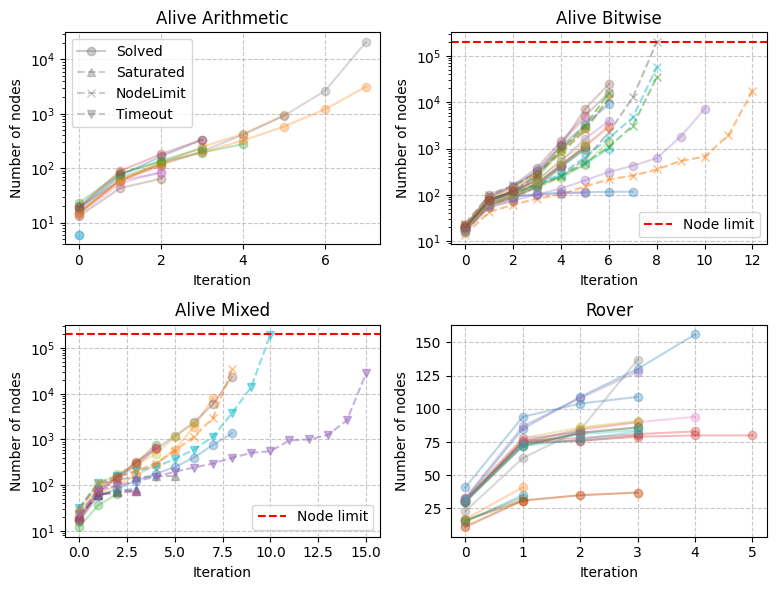

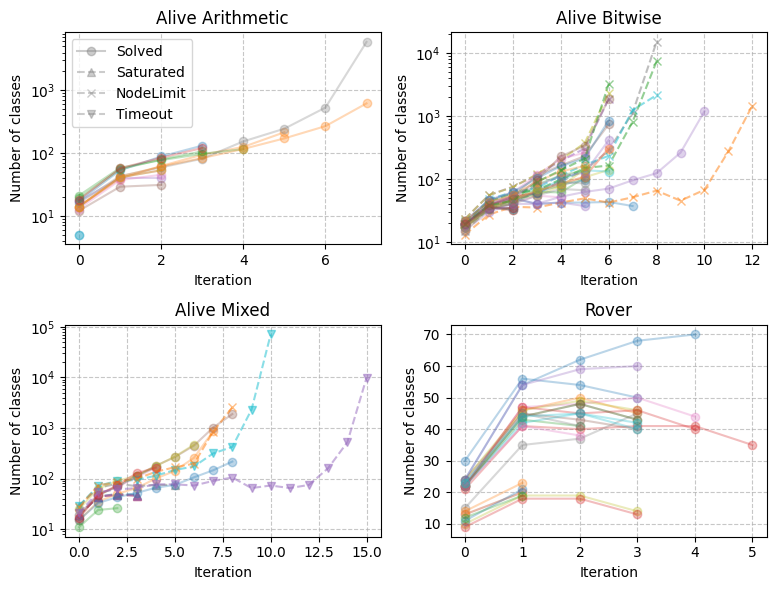

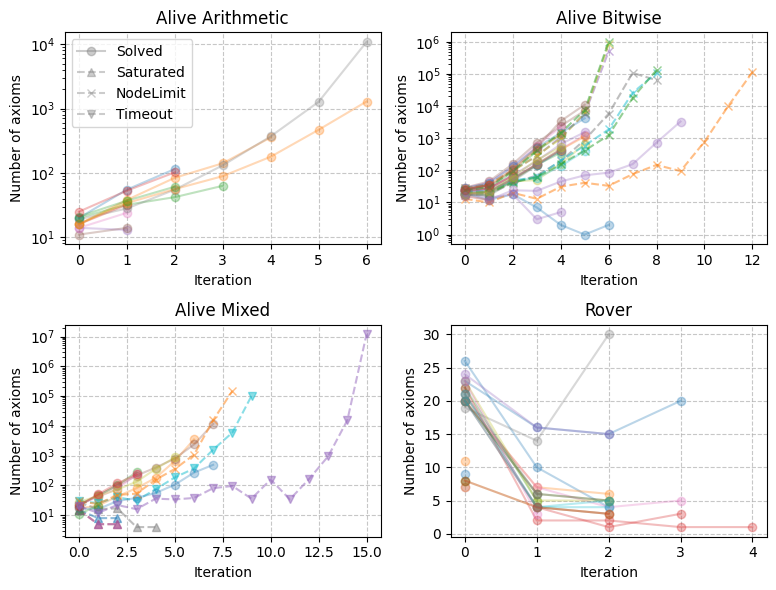

In [149]:
import numpy as np

NODE_LIMIT = 200_000

# plt.style.use('default')  # Reset to default first
# plt.rcParams.update({
#     "text.usetex": True,        # Use LaTeX to render all text
# "font.family": "serif",     # Use serif font (like LaTeX default)
# "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
# "font.size": 11,            # Match LaTeX document font size
# "axes.labelsize": 11,       # Axes label size
# "axes.titlesize": 11,       # Title size
# "legend.fontsize": 9,       # Legend font size
# "xtick.labelsize": 9,      # X tick label size
# "ytick.labelsize": 9,       # Y tick label size
# "figure.autolayout": True,  # Adjust layout automatically
# "axes.grid": True,          # Add grid (optional)
# "grid.alpha": 0.3,         # Grid transparency
# "lines.linewidth": 1.5,    # Line width
# "lines.markersize": 4,     # Marker size
# })

fail_marker = {
    'Saturated': '^',
    'NodeLimit': 'x',
    'Timeout': 'v'
}

for graph_name, fun in {
    "nodes": lambda x: x["egraph_nodes"],
    "classes": lambda x: x["egraph_classes"],
    "axioms": lambda x: sum([v for _k, v in x["applied"].items()]),
}.items():
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    for i, (bench, data) in enumerate(egraph_data.items()):
        ax = axs[i // 2][i % 2]
        any_unproven = False

        diffs = []
        maxs = []
        for theorem, info in data[0].items():
            iter_data = info["iteration_info"]

            y = []
            x = []
            x = [*range(0, len(iter_data))]
            for it in iter_data:
                # x.append((x[-1] if x != [] else 0) + it['total_time'])
                y.append(fun(it))
                # y.append(it['egraph_nodes'])
                # y.append(it['egraph_classes'])
                # y.append(sum([v for _k, v in it['applied'].items()]))
                # y.append(len(y) + 1)
            if graph_name == 'axioms':
                if y[-1] == 0:
                    y = y[:-1]
                    x = x[:-1]

            is_unproven = False
            satured = False
            if (reason := info["summary"]["stop_reason"]) != {
                "Other": "Found equivalence"
            }:
                satured = reason == "Saturated"
                # ax.text(x[-1], y[-1], theorem, horizontalalignment='center')
                is_unproven = True

            if is_unproven:
                ax.plot(x, y, f"--{fail_marker[parse_stop(info['summary']['stop_reason'])]}", alpha=0.5)
            else:
                ax.plot(x, y, "-o", alpha=0.3)

            if (non_zero := [t for t in y if t != 0]) != []:
                diffs.append(max(y) / min(non_zero))
            if y != []:
                maxs.append(max(y))
            any_unproven |= is_unproven

        if any([abs(m - NODE_LIMIT) < 50000 for m in maxs]):
            ax.axhline(NODE_LIMIT, color="red", linestyle="dashed", label="Node limit")
            ax.legend()

        ax.set_title(benchmark_names[bench])
        ax.set_xlabel("Iteration")
        ax.set_ylabel(f"Number of {graph_name}")
        # ax.set_yscale('function', functions=(lambda x: np.log(np.log(x)), lambda x: np.exp(np.exp(x))))
        if max(diffs) > 100:
            ax.set_yscale("log")

        ax.grid(True, linestyle="--", alpha=0.7)

    # Create custom legend for the first plot
    legend_elements = [
        plt.Line2D(
            [0], [0], color="grey", alpha=0.4, linestyle="-", marker="o", label="Solved"
        )] + [
        plt.Line2D(
            [0],
            [0],
            color="grey",
            alpha=0.4,
            linestyle="--",
            marker=v,
            label=k,
        ) for k,v in fail_marker.items()
            
        ]

    # Add legend to first subplot in the upper right corner
    axs[0, 0].legend(handles=legend_elements)

    plt.tight_layout()
    plt.savefig(f"{out_dir}bench_compare_{graph_name}.pdf")
    plt.show()